# 1D harmonic oscillator physics-informed neural network (PINN)

The main file is from the following repository, which is modified by M. Amintoosi

https://github.com/benmoseley/harmonic-oscillator-pinn

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [ ]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

In [6]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


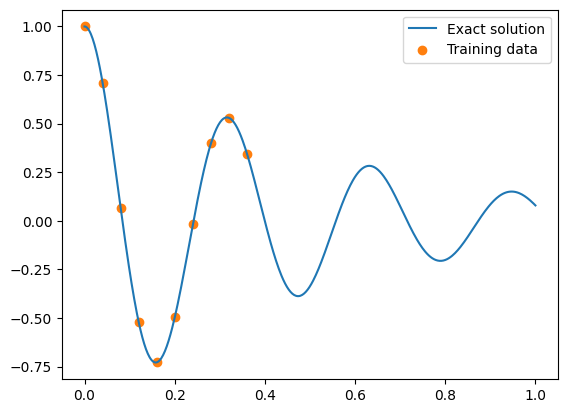

In [7]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [8]:
# Create plots folder for saving intermediate results
folder_name = 'plots'
if not os.path.exists(folder_name):
  os.makedirs(folder_name)

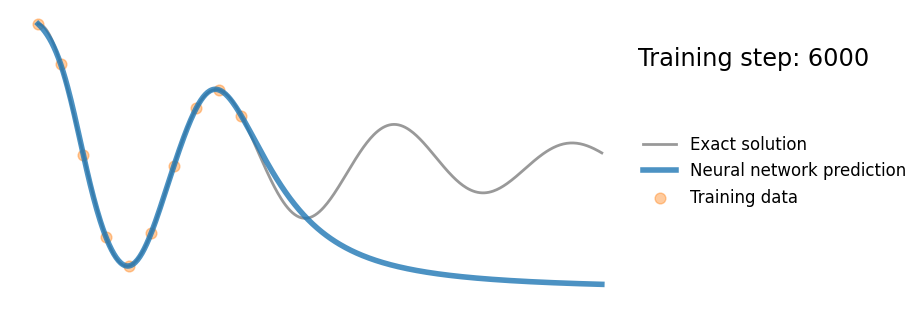

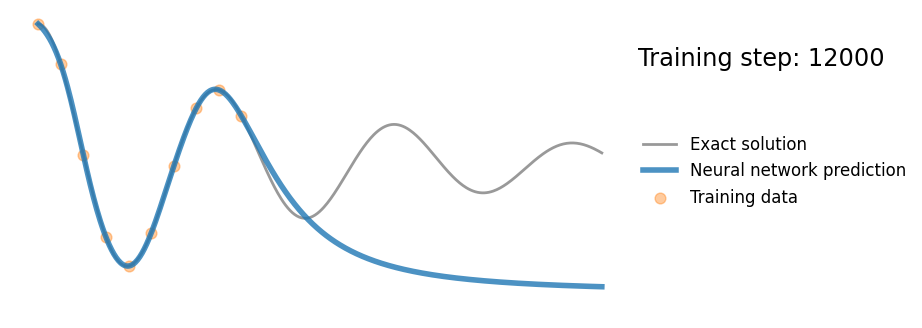

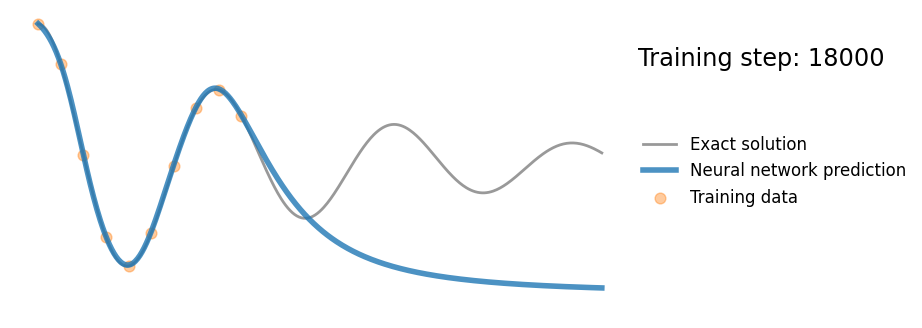

In [11]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(18000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 10 == 0:

        yh = model(x).detach()

        plot_result(x,y,x_data,y_data,yh)

        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("nn.gif", files, fps=20, loop=0)

# 新段落

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import firls, filtfilt
import time
from tqdm import tqdm # Progress bar

# --- 1. Parameters and ZERO Initial Conditions ---
M = 0.1
D = 0.001
K = 100.0
N_param = 0.0005
C_p = 1e-5
R = 100000.0

y0_forced = [0.0, 0.0, 0.0] # ZERO initial conditions for forced response

t_span = (0, 10)
# Use a fixed time grid for generating data and evaluating
T_MAX = t_span[1]
N_POINTS_TRAIN = 200 # Number of time points for each trajectory in training data
N_POINTS_EVAL = 500 # Number of time points for evaluation
t_eval_train = np.linspace(t_span[0], t_span[1], N_POINTS_TRAIN)
t_eval_vis = np.linspace(t_span[0], t_span[1], N_POINTS_EVAL)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move parameters to device
M_t = torch.tensor(M, device=device, dtype=torch.float32)
D_t = torch.tensor(D, device=device, dtype=torch.float32)
K_t = torch.tensor(K, device=device, dtype=torch.float32)
N_t = torch.tensor(N_param, device=device, dtype=torch.float32)
C_p_t = torch.tensor(C_p, device=device, dtype=torch.float32)
R_t = torch.tensor(R, device=device, dtype=torch.float32)

Using device: cpu


In [ ]:
# --- 2. Modified ODE System with Forcing Term ---
def system_ode_forced(t, y, R_val, force_func):
    w, w_dot, V_p = y
    F_ext = force_func(t)
    # Ensure params are float
    M_f, D_f, K_f, N_f, C_p_f = float(M), float(D), float(K), float(N_param), float(C_p)
    # Equation 1 with forcing term
    w_ddot = (F_ext - D_f * w_dot - K_f * w - N_f * V_p) / M_f
    # Equation 2 remains the same
    i_val = V_p / R_val
    V_p_dot = (N_f * w_dot - i_val) / C_p_f
    return [w_dot, w_ddot, V_p_dot]

# --- 3. Data Generation ---
def generate_data_sample(omega, amplitude, t_points):
    """Generates one training/testing sample."""
    force_func = lambda t: amplitude * np.sin(omega * t)
    sol = solve_ivp(lambda t, y: system_ode_forced(t, y, R, force_func),
                    t_span, y0_forced, t_eval=t_points, method='LSODA', rtol=1e-5, atol=1e-7)
    if not sol.success:
        print(f"Warning: ODE solver failed for omega={omega}, amp={amplitude}. Message: {sol.message}")
        return None, None
    # Input: force F_ext(t), Output: w(t), V_p(t)
    input_signal = force_func(sol.t)
    # Output: select w and Vp (index 0 and 2)
    output_signal = sol.y[[0, 2], :].T # Shape: (N_POINTS_TRAIN, 2)
    return input_signal, output_signal

def generate_dataset(num_samples, omega_range=(0.5, 15.0), amplitude_range=(0.001, 0.01), t_points=t_eval_train):
    """Generates a dataset of input/output function pairs."""
    X = [] # Input functions F_ext(t)
    Y = [] # Output functions [w(t), Vp(t)]
    print(f"Generating {num_samples} samples...")
    for _ in tqdm(range(num_samples)):
        omega = np.random.uniform(*omega_range)
        amplitude = np.random.uniform(*amplitude_range)
        inp, outp = generate_data_sample(omega, amplitude, t_points)
        if inp is not None and outp is not None:
            # Ensure consistent shape (N_POINTS_TRAIN, 1 or 2)
            if inp.ndim == 1: inp = inp[:, np.newaxis]
            if outp.ndim == 1: outp = outp[:, np.newaxis] # Should be (N, 2)
            X.append(inp)
            Y.append(outp)
    print(f"Generated {len(X)} valid samples.")
    # Stack into tensors: (num_samples, time_points, channels)
    return torch.tensor(np.stack(X), dtype=torch.float32), torch.tensor(np.stack(Y), dtype=torch.float32)



In [6]:
# --- Data Generation ---
NUM_TRAIN_SAMPLES = 1000
NUM_TEST_SAMPLES = 200
OMEGA_RANGE = (0.5, 15.0 * 2*np.pi) # Increase frequency range?
AMP_RANGE = (0.001, 0.01)

# Generate or load data
try:
    train_X = torch.load("lno_train_X.pt")
    train_Y = torch.load("lno_train_Y.pt")
    test_X = torch.load("lno_test_X.pt")
    test_Y = torch.load("lno_test_Y.pt")
    print("Loaded existing dataset.")
except FileNotFoundError:
    print("Generating new dataset...")
    train_X, train_Y = generate_dataset(NUM_TRAIN_SAMPLES, OMEGA_RANGE, AMP_RANGE, t_eval_train)
    test_X, test_Y = generate_dataset(NUM_TEST_SAMPLES, OMEGA_RANGE, AMP_RANGE, t_eval_train)
    torch.save(train_X, "lno_train_X.pt")
    torch.save(train_Y, "lno_train_Y.pt")
    torch.save(test_X, "lno_test_X.pt")
    torch.save(test_Y, "lno_test_Y.pt")
    print("Dataset generated and saved.")

# Create DataLoader
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Loaded existing dataset.


In [27]:
# --- 4. Numerical Laplace Transform and Inverse Transform ---
# These are simplified implementations. Robust numerical LT/ILT is complex.

def laplace_transform_numerical(f_t, t, s_real, s_imag_range, num_s_imag):
    """ Approximate Laplace Transform using numerical integration (trapezoidal)
        f_t: tensor (batch, time_points, channels)
        t: tensor (time_points,)
        s_real: float, real part of s (must be > max real part of poles)
        s_imag_range: tuple (min_imag, max_imag)
        num_s_imag: int, number of imaginary points
    """
    f_t = f_t.to(device)
    t = t.to(device)
    dt = t[1] - t[0]
    s_imag = torch.linspace(s_imag_range[0], s_imag_range[1], num_s_imag, device=device)
    s = s_real + 1j * s_imag # Complex s values (num_s_imag,)

    # Reshape for broadcasting:
    # t: (1, time, 1)
    # s: (1, 1, num_s_imag)
    t_r = t.reshape(1, -1, 1)
    s_r = s.reshape(1, 1, -1)
    f_t_r = f_t.permute(0, 2, 1) # (batch, channels, time) = (B, I, T)

    # Integrand: f(t) * exp(-st)
    # exp(-st): exp(-(s_real + j*s_imag) * t) = exp(-s_real*t) * exp(-j*s_imag*t)
    # Shape: (1, time, num_s_imag) = (1, T, S)
    exp_term = torch.exp(-s_r * t_r)

    # Integrand shape: (batch, channels, time, num_s_imag) = (B, I, T, S)
    # FIX: Correct broadcasting
    # f_t_r:         (B, I, T) -> unsqueeze(-1) -> (B, I, T, 1)
    # exp_term:      (1, T, S) -> unsqueeze(1)  -> (1, 1, T, S)
    # Result:                                        (B, I, T, S)
    integrand = f_t_r.unsqueeze(-1) * exp_term.unsqueeze(1)

    # Trapezoidal rule: sum[ (f(t_i)*exp(-st_i) + f(t_{i+1})*exp(-st_{i+1}))/2 * dt ]
    # Simplified: sum[ integrand ] * dt (approximate integral)
    # Integrate over time dimension (dim 2)
    F_s = torch.trapz(integrand, dx=dt.item(), dim=2)
    # F_s shape should now be: (batch, channels, num_s_imag) = (B, I, S)
    return F_s, s # Return transform and corresponding s values

def inverse_laplace_transform_weeks(F_s, s, t, sigma, b, M):
    """ Approximate Inverse Laplace Transform using Weeks method (Fixed Talbot)
        F_s: tensor (batch, channels, num_s_imag) - Laplace transform values
        s: tensor (num_s_imag,) - complex s values where F_s is evaluated
        t: tensor (num_time_points,) - time points for output f(t)
        sigma, b: floats - parameters for Weeks method contour (related to s_real)
        M: int - number of terms in the Weeks method summation
    """
    F_s = F_s.to(device)
    s = s.to(device) # Assuming s corresponds to the points used in Weeks! This is a mismatch.
    t = t.to(device)

    # Weeks method requires evaluating F(s) along a specific parabolic contour,
    # typically parameterized by theta. The provided F_s and s from numerical LT
    # are likely NOT on this contour. This is a major simplification/approximation.
    # We will *pretend* F_s corresponds to the required contour points.

    # Weeks contour parameterization (simplified):
    # s(theta) = sigma + b*(1j*theta + (1j*theta - 1)**2 / 4) for theta in [-pi, pi]
    # Or simpler Fixed Talbot contour: s = sigma + k*1j*cot(k*pi/M) / t
    # We'll use the simplified idea based on available F_s values.

    # Fixed Talbot / Weeks method simplified summation:
    # f(t) ≈ (exp(sigma*t)/M) * [ 0.5*F(sigma) + sum_{k=1}^{M-1} Re( F(s_k) * exp(1j*k*pi/M) ) ]
    # where s_k = sigma + k*pi*1j*(cot(k*pi/M)+1j)/ (t*M)
    # This requires evaluating F at specific s_k points, which we don't have directly.

    # --- Extremely Simplified Approximation ---
    # Use trapezoidal rule on the Bromwich integral along the given s contour
    # f(t) = (1 / (2*pi*j)) * integral[ F(s) * exp(st) ds ] from c-j*inf to c+j*inf
    # Approximate using the provided s values (s = s_real + j*s_imag)
    # ds = j * d(s_imag)

    s_imag = s.imag
    ds_imag = s_imag[1] - s_imag[0]
    ds = 1j * ds_imag

    # Reshape for broadcasting
    # F_s: (batch, channels, num_s)
    # s: (1, 1, num_s)
    # t: (num_t, 1, 1)
    s_r = s.reshape(1, 1, -1)
    t_r = t.reshape(-1, 1, 1)
    F_s_r = F_s # Already (batch, channels, num_s)

    # Integrand: F(s) * exp(st)
    # Shape: (batch, channels, num_s, num_t)
    exp_term = torch.exp(s_r * t_r) # Shape (num_t, 1, num_s)
    integrand = F_s_r.unsqueeze(0) * exp_term.unsqueeze(1) # Shape (num_t, batch, channels, num_s)
    integrand = integrand.permute(1, 2, 3, 0) # (batch, channels, num_s, num_t)


    # Integrate along s_imag axis (index 2) using trapezoidal rule
    # integral ≈ sum(integrand * ds)
    integral_val = torch.trapz(integrand, dx=ds_imag.item(), dim=2) # Integrate over s (index 2)
    # Result shape: (batch, channels, num_t)

    # f(t) = (1 / (2*pi)) * integral_val (ignoring the 1/j * j factor)
    f_t_approx = (1.0 / (2.0 * np.pi)) * integral_val.real # Take real part
    f_t_approx = f_t_approx.permute(0, 2, 1) # (batch, num_t, channels)
    return f_t_approx


class LaplaceLayer(nn.Module):
    """Implements the core LNO operation U(s) = K(s)V(s)."""
    def __init__(self, in_channels, out_channels, num_s_points, width=64):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_s_points = num_s_points

        # MLP to parameterize the kernel K(s) - weights are REAL
        self.kernel_mlp = nn.Sequential(
            nn.Linear(2, width), # Input: [real(s), imag(s)] - REAL features
            nn.GELU(),
            nn.Linear(width, width),
            nn.GELU(),
            nn.Linear(width, in_channels * out_channels * 2) # Output real/imag parts of K
        )
        # Ensure MLP parameters are float32 (usually default, but good to be explicit if needed)
        self.kernel_mlp.apply(self._init_weights) # Optional: init weights


    # Optional weight initialization
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # def forward(self, V_s, s):
    #     # ... (previous code) ...

    #     # Permute K to shape: (out_channels, in_channels, num_s) for batch matmul
    #     K = K_complex.permute(1, 2, 0)

    #     # --- DEBUG PRINT ---
    #     print(f"Shape of K: {K.shape}") # Expected: (O, I, S)
    #     print(f"Shape of V_s: {V_s.shape}") # Expected: (B, I, S)
    #     print(f"dtype of K: {K.dtype}")
    #     print(f"dtype of V_s: {V_s.dtype}")
    #     # --- END DEBUG ---

    #     # Apply the kernel: U(s) = K(s)V(s)
    #     U_s = torch.einsum('o i s, b i s -> b o s', K, V_s) # K is complex, V_s is complex

    #     return U_s

    def forward(self, V_s, s):
        # V_s: Input Laplace transform (batch, in_channels, num_s) - COMPLEX
        # s: Complex s values (num_s,) - COMPLEX
        batch_size = V_s.shape[0]

        # Prepare s for MLP: (num_s, 2) - Ensure it's REAL (Float)
        # FIX: Convert to FloatTensor explicitly
        s_real_imag = torch.stack([s.real, s.imag], dim=-1).to(torch.float32).to(device) # Use float32!

        # Compute K(s) components using MLP: (num_s, in_channels * out_channels * 2) - REAL output
        K_params = self.kernel_mlp(s_real_imag)

        # Reshape K_params to get complex K(s)
        # Shape: (num_s, out_channels, in_channels, 2) -> (num_s, out_channels, in_channels) complex
        # Ensure K_params is contiguous before view_as_complex
        K_params = K_params.contiguous()
        # FIX: Ensure K_params is float before viewing as complex (it should be from MLP)
        # Convert the REAL K_params into a COMPLEX tensor K_complex
        K_complex = torch.view_as_complex(
            K_params.reshape(self.num_s_points, self.out_channels, self.in_channels, 2)
        )

        # Permute K to shape: (out_channels, in_channels, num_s) for batch matmul
        K = K_complex.permute(1, 2, 0)

         # --- DEBUG PRINT ---
        print(f"Shape of K: {K.shape}") # Expected: (O, I, S)
        print(f"Shape of V_s: {V_s.shape}") # Expected: (B, I, S)
        print(f"dtype of K: {K.dtype}")
        print(f"dtype of V_s: {V_s.dtype}")

        # Apply the kernel: U(s) = K(s)V(s)
        # K is complex, V_s is complex. Einsum should work fine.
        U_s = torch.einsum('o i s, b i s -> b o s', K, V_s) # K is complex, V_s is complex

        return U_s

class LNO_Model(nn.Module):
    def __init__(self, in_channels, out_channels, T_max,
                 num_time_points, s_real=1.0, s_imag_range=(-30.0, 30.0), num_s_imag=200,
                 ilt_sigma=None, ilt_b=None, ilt_M=20, # Weeks params
                 laplace_layer_width=64):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.T_max = T_max
        self.num_time_points = num_time_points
        self.t_grid = torch.linspace(0, T_max, num_time_points, device=device)

        # Laplace Transform parameters
        self.s_real = s_real
        self.s_imag_range = s_imag_range
        self.num_s_imag = num_s_imag

        # Inverse Laplace Transform parameters (Weeks/Talbot style)
        # Defaults should be related to s_real and T_max
        self.ilt_sigma = ilt_sigma if ilt_sigma is not None else s_real
        self.ilt_b = ilt_b if ilt_b is not None else num_s_imag / (T_max * 1.5) # Heuristic
        self.ilt_M = ilt_M

        # Core Laplace Layer
        self.laplace_layer = LaplaceLayer(in_channels, out_channels, num_s_imag, laplace_layer_width)

        # Optional: Lifting/Projection layers (like FNO) - skip for simplicity now

    def forward(self, v_t):
        # v_t: input time series (batch, time_points, in_channels)

        # 1. Numerical Laplace Transform
        V_s, s_complex = laplace_transform_numerical(
            v_t, self.t_grid, self.s_real, self.s_imag_range, self.num_s_imag
        )
        # V_s shape: (batch, in_channels, num_s_imag)
        # s_complex shape: (num_s_imag,)

        # 2. Apply Laplace Layer K(s)
        U_s = self.laplace_layer(V_s, s_complex)
        # U_s shape: (batch, out_channels, num_s_imag)

        # 3. Numerical Inverse Laplace Transform
        # Note: The ILT needs F(s) evaluated on the ILT contour, our V_s/U_s are not.
        # We pass the original s_complex for now, acknowledging the approximation.
        u_t_pred = inverse_laplace_transform_weeks(
            U_s, s_complex, self.t_grid, self.ilt_sigma, self.ilt_b, self.ilt_M
        )
        # u_t_pred shape: (batch, time_points, out_channels)

        return u_t_pred


In [29]:
class LaplaceLayer(nn.Module):
    """Implements the core LNO operation U(s) = K(s)V(s)."""
    def __init__(self, in_channels, out_channels, num_s_points, width=64):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_s_points = num_s_points

        # MLP to parameterize the kernel K(s) - weights are REAL
        self.kernel_mlp = nn.Sequential(
            nn.Linear(2, width), # Input: [real(s), imag(s)] - REAL features
            nn.GELU(),
            nn.Linear(width, width),
            nn.GELU(),
            nn.Linear(width, in_channels * out_channels * 2) # Output real/imag parts of K
        )
        # Ensure MLP parameters are float32 (usually default, but good to be explicit if needed)
        self.kernel_mlp.apply(self._init_weights) # Optional: init weights


    # Optional weight initialization
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # def forward(self, V_s, s):
    #     # ... (previous code) ...

    #     # Permute K to shape: (out_channels, in_channels, num_s) for batch matmul
    #     K = K_complex.permute(1, 2, 0)

    #     # --- DEBUG PRINT ---
    #     print(f"Shape of K: {K.shape}") # Expected: (O, I, S)
    #     print(f"Shape of V_s: {V_s.shape}") # Expected: (B, I, S)
    #     print(f"dtype of K: {K.dtype}")
    #     print(f"dtype of V_s: {V_s.dtype}")
    #     # --- END DEBUG ---

    #     # Apply the kernel: U(s) = K(s)V(s)
    #     U_s = torch.einsum('o i s, b i s -> b o s', K, V_s) # K is complex, V_s is complex

    #     return U_s

    def forward(self, V_s, s):
        # V_s: Input Laplace transform (batch, in_channels, num_s) - COMPLEX
        # s: Complex s values (num_s,) - COMPLEX
        batch_size = V_s.shape[0]

        # Prepare s for MLP: (num_s, 2) - Ensure it's REAL (Float)
        # FIX: Convert to FloatTensor explicitly
        s_real_imag = torch.stack([s.real, s.imag], dim=-1).to(torch.float32).to(device) # Use float32!

        # Compute K(s) components using MLP: (num_s, in_channels * out_channels * 2) - REAL output
        K_params = self.kernel_mlp(s_real_imag)

        # Reshape K_params to get complex K(s)
        # Shape: (num_s, out_channels, in_channels, 2) -> (num_s, out_channels, in_channels) complex
        # Ensure K_params is contiguous before view_as_complex
        K_params = K_params.contiguous()
        # FIX: Ensure K_params is float before viewing as complex (it should be from MLP)
        # Convert the REAL K_params into a COMPLEX tensor K_complex
        K_complex = torch.view_as_complex(
            K_params.reshape(self.num_s_points, self.out_channels, self.in_channels, 2)
        )

        # Permute K to shape: (out_channels, in_channels, num_s) for batch matmul
        K = K_complex.permute(1, 2, 0)

         # --- DEBUG PRINT ---
        # print(f"Shape of K: {K.shape}") # Expected: (O, I, S)
        # print(f"Shape of V_s: {V_s.shape}") # Expected: (B, I, S)
        # print(f"dtype of K: {K.dtype}")
        # print(f"dtype of V_s: {V_s.dtype}")

        # Apply the kernel: U(s) = K(s)V(s)
        # K is complex, V_s is complex. Einsum should work fine.
        U_s = torch.einsum('o i s, b i s -> b o s', K, V_s) # K is complex, V_s is complex

        return U_s

class LNO_Model(nn.Module):
    def __init__(self, in_channels, out_channels, T_max,
                 num_time_points, s_real=1.0, s_imag_range=(-30.0, 30.0), num_s_imag=200,
                 ilt_sigma=None, ilt_b=None, ilt_M=20, # Weeks params
                 laplace_layer_width=64):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.T_max = T_max
        self.num_time_points = num_time_points
        self.t_grid = torch.linspace(0, T_max, num_time_points, device=device)

        # Laplace Transform parameters
        self.s_real = s_real
        self.s_imag_range = s_imag_range
        self.num_s_imag = num_s_imag

        # Inverse Laplace Transform parameters (Weeks/Talbot style)
        # Defaults should be related to s_real and T_max
        self.ilt_sigma = ilt_sigma if ilt_sigma is not None else s_real
        self.ilt_b = ilt_b if ilt_b is not None else num_s_imag / (T_max * 1.5) # Heuristic
        self.ilt_M = ilt_M

        # Core Laplace Layer
        self.laplace_layer = LaplaceLayer(in_channels, out_channels, num_s_imag, laplace_layer_width)

        # Optional: Lifting/Projection layers (like FNO) - skip for simplicity now

    def forward(self, v_t):
        # v_t: input time series (batch, time_points, in_channels)

        # 1. Numerical Laplace Transform
        V_s, s_complex = laplace_transform_numerical(
            v_t, self.t_grid, self.s_real, self.s_imag_range, self.num_s_imag
        )
        # V_s shape: (batch, in_channels, num_s_imag)
        # s_complex shape: (num_s_imag,)

        # 2. Apply Laplace Layer K(s)
        U_s = self.laplace_layer(V_s, s_complex)
        # U_s shape: (batch, out_channels, num_s_imag)

        # 3. Numerical Inverse Laplace Transform
        # Note: The ILT needs F(s) evaluated on the ILT contour, our V_s/U_s are not.
        # We pass the original s_complex for now, acknowledging the approximation.
        u_t_pred = inverse_laplace_transform_weeks(
            U_s, s_complex, self.t_grid, self.ilt_sigma, self.ilt_b, self.ilt_M
        )
        # u_t_pred shape: (batch, time_points, out_channels)

        return u_t_pred
# --- 6. Training Loop ---
def train_lno(model, train_loader, epochs, lr, weight_decay=1e-5):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss() # Time-domain loss

    history = {'train_loss': [], 'epoch': []}
    print("Starting LNO Training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            # batch_x: (batch, time, in_channels=1)
            # batch_y: (batch, time, out_channels=2)

            optimizer.zero_grad()
            pred_y = model(batch_x)
            loss = criterion(pred_y, batch_y)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_epoch_loss)
        history['epoch'].append(epoch)
        scheduler.step()

        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_epoch_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.2e}")

    print("Training finished.")
    return model, history
in_channels = 1 # Input is F_ext(t)
out_channels = 2 # Output is [w(t), Vp(t)]
model = LNO_Model(in_channels=in_channels, out_channels=out_channels,
                  T_max=T_MAX, num_time_points=N_POINTS_TRAIN,
                  s_real=1.0, # sigma > max real part of system poles
                  s_imag_range=(-40, 40), # Wider range for higher frequencies
                  num_s_imag=256, # More points in s domain
                  laplace_layer_width=128) # Wider MLP for kernel

 # --- Training ---
EPOCHS = 150 # Adjust as needed
LEARNING_RATE = 1e-3

trained_model, history = train_lno(model, train_loader, epochs=EPOCHS, lr=LEARNING_RATE)

Starting LNO Training...
Epoch 10/150, Train Loss: 0.000104, LR: 9.89e-04
Epoch 20/150, Train Loss: 0.000105, LR: 9.57e-04
Epoch 30/150, Train Loss: 0.000158, LR: 9.05e-04
Epoch 40/150, Train Loss: 0.000103, LR: 8.35e-04
Epoch 50/150, Train Loss: 0.000106, LR: 7.50e-04


KeyboardInterrupt: 

Starting LNO Training...
Epoch 10/150, Train Loss: 0.000137, LR: 9.89e-04
Epoch 20/150, Train Loss: 0.000103, LR: 9.57e-04
Epoch 30/150, Train Loss: 0.000123, LR: 9.05e-04
Epoch 40/150, Train Loss: 0.000103, LR: 8.35e-04
Epoch 50/150, Train Loss: 0.000104, LR: 7.50e-04
Epoch 60/150, Train Loss: 0.000103, LR: 6.55e-04
Epoch 70/150, Train Loss: 0.000102, LR: 5.52e-04
Epoch 80/150, Train Loss: 0.000107, LR: 4.48e-04
Epoch 90/150, Train Loss: 0.000103, LR: 3.45e-04
Epoch 100/150, Train Loss: 0.000101, LR: 2.50e-04
Epoch 110/150, Train Loss: 0.000103, LR: 1.65e-04
Epoch 120/150, Train Loss: 0.000102, LR: 9.55e-05
Epoch 130/150, Train Loss: 0.000101, LR: 4.32e-05
Epoch 140/150, Train Loss: 0.000101, LR: 1.09e-05
Epoch 150/150, Train Loss: 0.000101, LR: 0.00e+00
Training finished.

--- Evaluation Results (lno) ---
Average Relative L2 Error (on 5 samples): 1.1211e+00
Average MSE (on 5 samples): 8.6470e-07


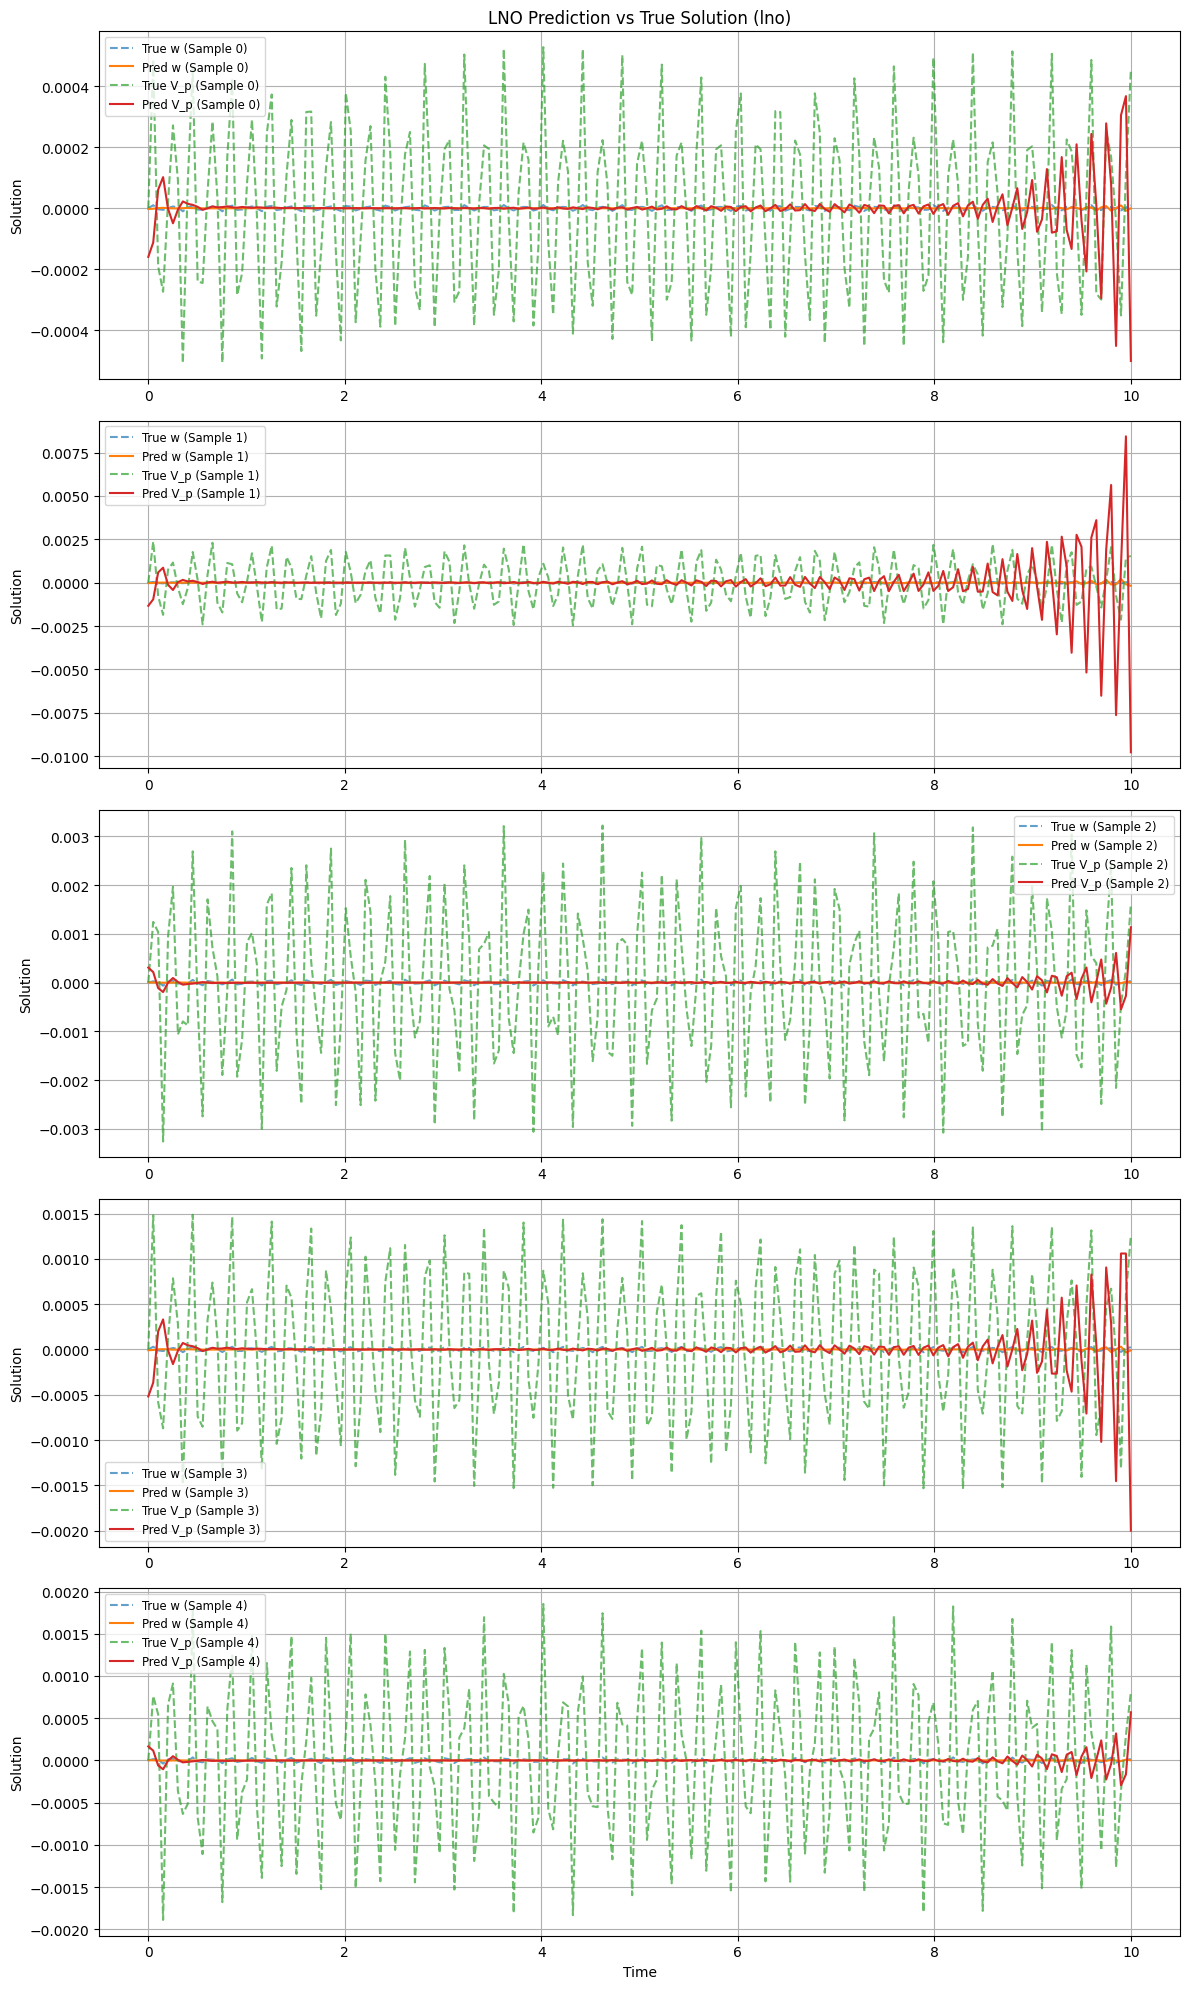

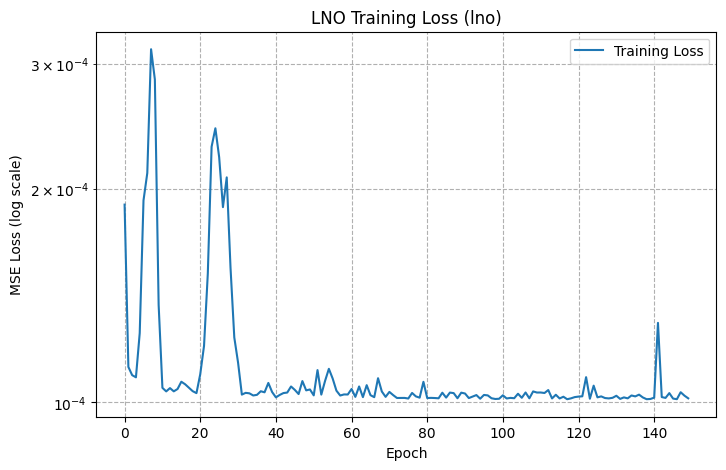


Predicting for a new frequency (omega=5*pi)...
Visualizing based on model's output resolution.


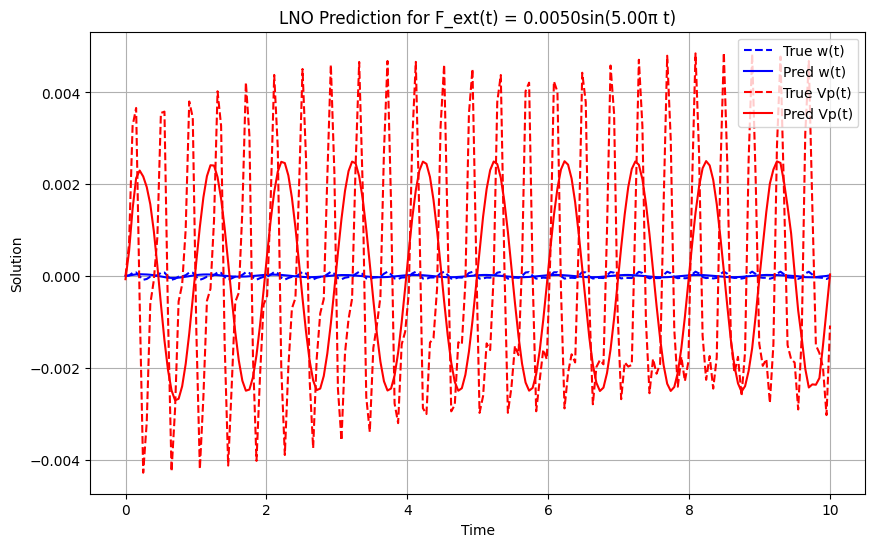

In [32]:
# --- 7. Evaluation and Visualization ---
def evaluate_and_visualize_lno(model, test_X, test_Y, t_points, suffix='lno'):
    model.eval()
    with torch.no_grad():
        pred_Y = model(test_X.to(device)).cpu()

    num_samples_to_plot = min(5, test_X.shape[0])
    num_outputs = test_Y.shape[2] # Should be 2 (w, Vp)
    var_names = ['w', 'V_p']

    plt.figure(figsize=(12, 4 * num_samples_to_plot))
    print(f"\n--- Evaluation Results ({suffix}) ---")

    total_rel_l2_error = 0.0
    total_mse = 0.0

    for i in range(num_samples_to_plot):
        plt.subplot(num_samples_to_plot, 1, i + 1)
        true_y_sample = test_Y[i].numpy() # (time, out_channels)
        pred_y_sample = pred_Y[i].numpy()

        sample_rel_l2 = np.linalg.norm(true_y_sample - pred_y_sample) / np.linalg.norm(true_y_sample)
        sample_mse = np.mean((true_y_sample - pred_y_sample)**2)
        total_rel_l2_error += sample_rel_l2
        total_mse += sample_mse

        # Plot individual components
        for j in range(num_outputs):
            plt.plot(t_points, true_y_sample[:, j], '--', label=f'True {var_names[j]} (Sample {i})', alpha=0.7)
            plt.plot(t_points, pred_y_sample[:, j], '-', label=f'Pred {var_names[j]} (Sample {i})')

        plt.ylabel('Solution')
        plt.legend(fontsize='small')
        plt.grid(True)
        if i == 0: plt.title(f'LNO Prediction vs True Solution ({suffix})')
        if i == num_samples_to_plot - 1: plt.xlabel('Time')

    avg_rel_l2 = total_rel_l2_error / num_samples_to_plot
    avg_mse = total_mse / num_samples_to_plot
    print(f"Average Relative L2 Error (on {num_samples_to_plot} samples): {avg_rel_l2:.4e}")
    print(f"Average MSE (on {num_samples_to_plot} samples): {avg_mse:.4e}")

    plt.tight_layout()
    plt.savefig(f'lno_results_{suffix}.png')
    plt.show()

def plot_lno_loss(history, suffix='lno'):
     plt.figure(figsize=(8, 5))
     plt.semilogy(history['epoch'], history['train_loss'], label='Training Loss')
     plt.xlabel('Epoch')
     plt.ylabel('MSE Loss (log scale)')
     plt.title(f'LNO Training Loss ({suffix})')
     plt.grid(True, which='both', ls='--')
     plt.legend()
     plt.savefig(f'lno_loss_{suffix}.png')
     plt.show()
# --- Evaluation ---
# Use the same time points for evaluation as training for consistency here
# --- Training ---

EPOCHS = 150 # Adjust as needed
LEARNING_RATE = 1e-3

trained_model, history = train_lno(model, train_loader, epochs=EPOCHS, lr=LEARNING_RATE)

evaluate_and_visualize_lno(trained_model, test_X, test_Y, t_eval_train, suffix='lno')
plot_lno_loss(history, suffix='lno')

# --- Example: Predict for a specific new frequency ---
print("\nPredicting for a new frequency (omega=5*pi)...")
test_omega = 5.0 * np.pi
test_amp = 0.005
inp_new, outp_new_true = generate_data_sample(test_omega, test_amp, t_eval_vis)
if inp_new is not None:
    inp_new_t = torch.tensor(inp_new, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device) # (1, time, 1)
    trained_model.eval()
    with torch.no_grad():
          # Need to ensure the model uses the correct t_grid for prediction
          # If model's t_grid differs from t_eval_vis, need interpolation or retrain model
          # Assuming model uses N_POINTS_TRAIN internally for t_grid:
          if N_POINTS_TRAIN != N_POINTS_EVAL:
              print("Warning: Model internal time grid differs from visualization grid.")
              print("Visualizing based on model's output resolution.")
              eval_t_points_viz = np.linspace(t_span[0], t_span[1], N_POINTS_TRAIN) # Use model's grid
              # Regenerate true solution on this grid for comparison
              _, outp_new_true_viz = generate_data_sample(test_omega, test_amp, eval_t_points_viz)
          else:
              eval_t_points_viz = t_eval_vis
              outp_new_true_viz = outp_new_true

          pred_y_new = trained_model(inp_new_t[:, :N_POINTS_TRAIN, :]).cpu().squeeze(0).numpy() # Predict on model's grid


    plt.figure(figsize=(10, 6))
    plt.plot(eval_t_points_viz, outp_new_true_viz[:, 0], 'b--', label='True w(t)')
    plt.plot(eval_t_points_viz, pred_y_new[:, 0], 'b-', label='Pred w(t)')
    plt.plot(eval_t_points_viz, outp_new_true_viz[:, 1], 'r--', label='True Vp(t)')
    plt.plot(eval_t_points_viz, pred_y_new[:, 1], 'r-', label='Pred Vp(t)')
    plt.xlabel("Time")
    plt.ylabel("Solution")
    plt.title(f"LNO Prediction for F_ext(t) = {test_amp:.4f}sin({test_omega/np.pi:.2f}π t)")
    plt.legend()
    plt.grid(True)
    plt.savefig("lno_single_prediction.png")
    plt.show()